<a href="https://colab.research.google.com/github/yashb98/90Days_Machine_learinng/blob/main/Customer_Churn__Prediction_Using_Pytorch_Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries



In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

	•	torch handles model creation and training.
	•	sklearn handles splitting, scaling, and evaluation.
	•	seaborn + matplotlib for visualization — essential to interpret model performance.

## Data Loading and Cleaning

In [22]:
# Load dataset
df = pd.read_excel("/content/Telco_customer_churn.xlsx")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [23]:
# Drop irrelevant columns
df.drop(["CustomerID", "Country", "State", "City", "Zip Code", "Lat Long", "Churn Reason"], axis=1, inplace=True)



In [24]:
# Convert 'Total Charges' to numeric
df["Total Charges"] = pd.to_numeric(df["Total Charges"], errors="coerce")
df["Total Charges"].fillna(df["Total Charges"].median(), inplace=True)



/tmp/ipython-input-3546272182.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Total Charges"].fillna(df["Total Charges"].median(), inplace=True)


In [25]:
# Target column
target = "Churn Value"

# Drop possible duplicate label columns
df.drop(["Churn Label"], axis=1, inplace=True, errors='ignore')



In [26]:
# Split features and labels
X = df.drop(columns=[target])
y = df[target]



In [27]:
# Ensure all categorical columns are properly encoded
cat_cols = X.select_dtypes(include=["object"]).columns
# One-hot encode categorical variables
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)



In [28]:
# Check: all numeric
assert all(X.dtypes != "object"), "Some columns are still non-numeric!"

In [30]:
# Standardize numerical columns
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


StandardScaler is a data preprocessing technique from sklearn.preprocessing that standardizes (or normalizes) numerical features so that they all have a mean of 0 and a standard deviation of 1.

This process is often referred to as Z-score normalisation.

**How it works mathematically**

For each numerical feature x:


    z = \frac{x - \mu}{\sigma}

Where:

	•	\mu = mean of the feature
	•	\sigma = standard deviation of the feature
	•	z = standardized value

After scaling:

	•	Mean of the column → 0
	•	Standard deviation → 1

This ensures all features are on the same scale, preventing large-valued features (like “Salary” or “Age”) from dominating others in machine learning algorithms.


In [40]:
# Convert to tensors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

	1.	Split your data into train and test sets while preserving class distribution.
	2.	Convert features and labels into PyTorch tensors.
	3.	Reshape labels into column vectors for PyTorch models.

## Create a Data Loader ( Mini-Batch Training )

In [41]:
# Create TensorDataset and DataLoader
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)



In PyTorch, **`TensorDataset`** and **`DataLoader`** are utilities that help organize and efficiently feed data to a model during training and testing.

- **`TensorDataset`**:  
  A dataset wrapping tensors. Each sample will be retrieved by indexing tensors along the first dimension.  
  It allows us to combine input features (`X_train`) and target labels (`y_train`) into a single dataset object that can be easily accessed in batches.

  ```python
  train_data = TensorDataset(X_train, y_train)
  test_data = TensorDataset(X_test, y_test)

**Why use DataLoader?**

Instead of feeding all data at once (which is inefficient and memory-heavy),
DataLoader splits it into mini-batches, allowing:

	•	Faster convergence
	•	Less memory usage
	•	Better generalization

## Define the ANN Model



Since this is a binary classification (churn or not churn), we’ll use:

	•	Input layer = number of features in your dataset
	•	Hidden layers = at least 2 (to capture nonlinear patterns)
	•	Output layer = 1 neuron (for probability of churn)
	•	Activation = ReLU (hidden) + Sigmoid (output)


In [43]:
import torch.nn as nn

class ChurnANN(nn.Module):
    def __init__(self, input_dim):
        super(ChurnANN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x

# Instantiate model
input_dim = X_train.shape[1]
model = ChurnANN(input_dim)

### 📘 ChurnANN Model Explanation

In PyTorch, we define neural networks by **subclassing `nn.Module`**. Here, `ChurnANN` is a simple feedforward **Artificial Neural Network (ANN)** for binary classification (predicting churn).

#### Model Components:

1. **`nn.Linear`**  
   - Definition: Fully connected (dense) layer that performs a linear transformation:  
     \[
     y = xW^T + b
     \]  
   - Usage: Transforms input features into higher-level representations.  
     - `layer1`: input_dim → 64 neurons  
     - `layer2`: 64 → 32 neurons  
     - `output`: 32 → 1 neuron (for binary output)

2. **`nn.ReLU` (Rectified Linear Unit)**  
   - Definition: Activation function defined as \( \text{ReLU}(x) = \max(0, x) \)  
   - Why used:  
     - Introduces **non-linearity** so the network can learn complex patterns.  
     - Prevents vanishing gradient problems compared to sigmoid/tanh in hidden layers.  

3. **`nn.Dropout`**  
   - Definition: Randomly sets a fraction of input units to 0 during training.  
   - Why used:  
     - Helps **prevent overfitting** by making the network less sensitive to specific neurons.  
     - In this model, `Dropout(0.3)` randomly drops 30% of neurons during each forward pass in training.

4. **`nn.Sigmoid`**  
   - Definition: Activation function defined as  
     \[
     \sigma(x) = \frac{1}{1 + e^{-x}}
     \]  
   - Output range: (0, 1)  
   - Why used:  
     - Converts the final output into a **probability** for binary classification (churn vs no churn).  
     - Ensures the model output is suitable for **BCELoss** (Binary Cross-Entropy Loss).

#### Forward Pass:

```python
x = self.relu(self.layer1(x))   # Hidden layer 1 + ReLU
x = self.dropout(x)             # Apply dropout
x = self.relu(self.layer2(x))   # Hidden layer 2 + ReLU
x = self.dropout(x)             # Apply dropout
x = self.sigmoid(self.output(x))# Output layer + Sigmoid

## Loss Function and Optimizer

In [44]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.8)

1. Binary Cross-Entropy (BCELoss) measures how close predicted probabilities are to the true labels (1 = churn, 0 = stay).

2. Adam automatically adjusts learning rate and converges faster than SGD.

3. StepLR reduces the learning rate every 25 epochs by 20%, helping fine-tune training.
  


## Training Loop

In [45]:
epochs = 100
train_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    scheduler.step()  # update learning rate
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Avg Loss: {avg_loss:.4f}")

Epoch [10/100] - Avg Loss: 0.1825
Epoch [20/100] - Avg Loss: 0.1635
Epoch [30/100] - Avg Loss: 0.1535
Epoch [40/100] - Avg Loss: 0.1493
Epoch [50/100] - Avg Loss: 0.1410
Epoch [60/100] - Avg Loss: 0.1369
Epoch [70/100] - Avg Loss: 0.1334
Epoch [80/100] - Avg Loss: 0.1264
Epoch [90/100] - Avg Loss: 0.1427
Epoch [100/100] - Avg Loss: 0.1176


	•	Each epoch updates weights once using all training data.
	•	We monitor loss every 10 epochs to ensure convergence.
	•	If the loss stops decreasing, we might lower the learning rate or use early stopping.

## Visualise Training Loss

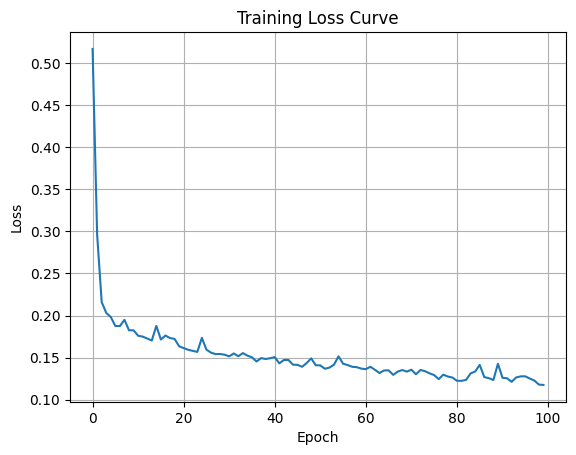

In [46]:
plt.plot(train_losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Model Evaluation


✅ Test Accuracy: 91.63%

Classification Report:
              precision    recall  f1-score   support

         0.0      0.942     0.944     0.943      1035
         1.0      0.844     0.840     0.842       374

    accuracy                          0.916      1409
   macro avg      0.893     0.892     0.892      1409
weighted avg      0.916     0.916     0.916      1409



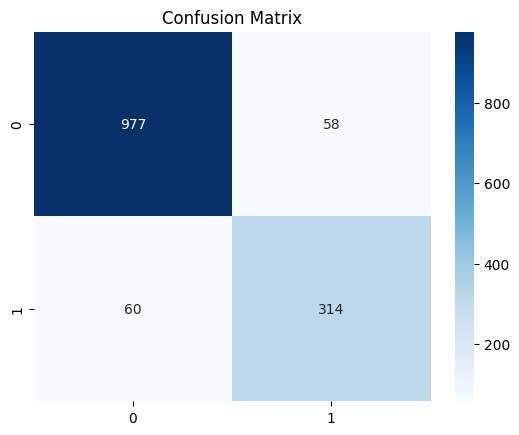

In [48]:
model.eval()
with torch.no_grad():
    y_pred = []
    for X_batch, _ in test_loader:
        preds = model(X_batch)
        y_pred.append(preds)
    y_pred = torch.cat(y_pred)
    y_pred_cls = (y_pred >= 0.5).float()

# Accuracy
acc = accuracy_score(y_test, y_pred_cls)
print(f"\n✅ Test Accuracy: {acc*100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_cls, digits=3))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_cls)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

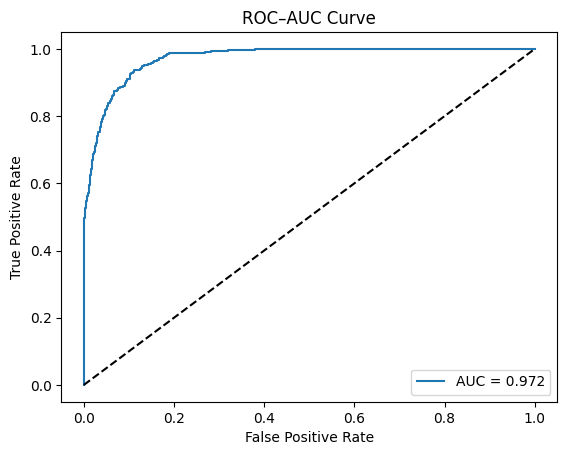

In [50]:
y_pred_probs = y_pred.numpy()
y_true = y_test.numpy()

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
auc = roc_auc_score(y_true, y_pred_probs)

plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC–AUC Curve")
plt.legend()
plt.show()

	•	ROC–AUC helps evaluate how well your model distinguishes between churners and non-churners, even in imbalanced data.
	•	AUC closer to 1 → excellent model; around 0.5 → random guessing.


## Analysis

####The notebook performs a binary classification task to predict customer churn using an Artificial Neural Network (ANN) with PyTorch. The data is loaded, preprocessed by dropping irrelevant columns and handling missing values in 'Total Charges'. Categorical features are one-hot encoded, and numerical features are scaled using `StandardScaler`. The data is then split into training and testing sets and converted to PyTorch tensors and `DataLoader` objects for efficient training.

####The ANN model consists of two hidden layers with ReLU activation and dropout for regularization, and an output layer with a Sigmoid activation for binary classification. The model is trained using the Adam optimizer and BCELoss as the criterion. A learning rate scheduler is also used to adjust the learning rate during training.

####The training loss curve shows a general decreasing trend, indicating that the model is learning. The evaluation metrics on the test set show a test accuracy of 91.63%. The classification report provides precision, recall, and f1-score for both churn (1.0) and non-churn (0.0) classes. The confusion matrix visually represents the true positives, true negatives, false positives, and false negatives. The ROC-AUC curve and AUC score of 0.972 demonstrate the model's ability to distinguish between the two classes.

## Conclusion

The developed ANN model demonstrates good performance in predicting customer churn with a test accuracy of over 91% and a high AUC score. The training process shows convergence, and the evaluation metrics indicate that the model is able to effectively classify customers as either churners or non-churners.

## Summary

This notebook successfully implements and trains an Artificial Neural Network for customer churn prediction. The data preprocessing steps, model architecture, training procedure, and evaluation metrics are clearly defined and executed. The results suggest that the model is a promising tool for identifying customers at risk of churning. Further improvements could involve hyperparameter tuning, exploring different model architectures, or incorporating additional feature engineering.